In [1]:
import numpy as np

from matplotlib import pyplot as plt
from tqdm import tqdm

%matplotlib inline

In [2]:
class Input(object):
    def __init__(self,input_shape,activation=None):
        self.input_shape = input_shape
        self.activation  = activation
        pass
    
    def forward(self,x):
        if x.shape != self.input_shape:
            raise Exception('Exception: x.shape != self.input_shape')
        return x
    
    def __rep__(self):
        return "{0}".format(self.__class__)
    
    def __str__(self):
        return "Input shape : {0}".format(self.input_shape)

In [3]:
class Dense(object):
    def __init__(self,inputs, units, activation, learning_rate=None):
        self.activation = activation
        self.inputs = inputs
        self.units = units
        
        self.weights = np.random.rand(inputs,units)
        
        if learning_rate is None:
            learning_rate = 0.5
        self.learning_rate = learning_rate
        pass
    
    def forward(self,x):
        self.activated = self.activation((np.dot(self.weights.T,x)))
        return self.activated
    
    def update(self,x):
        self.weights -= x*self.learning_rate
        pass
    
    def __rep__(self):
        return "{0}".format(self.__class__)
    
    def __str__(self):
        return "{0}".format(self.weights.shape)

In [4]:
class Model(object):
    def __init__(self, layers=[],placeholder=None):
        self.placeholder = placeholder
        self.layers = layers
        pass
    
    def add(self,layer=None):
        self.layers.append(layer)
        pass
    
    def fit(self,x,labels,epochs,loss, prime):
        history = []
        for _ in tqdm(range(epochs)):
            total_cost = 0.0
            for i in range(len(x_train)):
                xx = np.array(x[i])
                yy = np.array(labels[i])
                
                # Forward propagation
                signals = self.forward(xx)
                
                # Backpropagation
                cost, weights = self.backpropagation(yy,loss,prime,signals)
                total_cost += cost
                
                # Update weights
                self.update(weights)
                
            history.append(total_cost/len(x_train))
            
        return history
    
    def forward(self, x):
        signals = []
        y = x
        for layer in self.layers:
            y = layer.forward(y)
            signals.append(y)
        return signals
    
    def backpropagation(self,expected,loss,prime,signals=[]):
        weights = []
        last = len(self.layers)-1
        pred = signals[last]
        
        # Cost
        diff = pred-expected
        cost = loss(diff)
                
        # Back propagation
        common = ((diff)*prime(pred)).T
        weights.append(np.dot(signals[last-1],common))
        
        for i in range((last-2),-1,-1):
            common = np.dot(common,self.layers[i+2].weights.T)*prime(signals[i+1].T)
            w = np.dot(signals[i],(common))
            weights.append(w)
        return cost, reversed(weights)
    
    def update(self,weights):
        for i,weight in enumerate(weights):
            self.layers[i+1].update(weight)
        pass
    
    def predict(self,x):
        return self.forward(x)[(len(self.layers)-1)]
    
    def evaluate(self,x,labels):
        correct = 0
        for i,d in enumerate(x):
            pred = self.predict(d)
            if np.argmax(pred) == np.argmax(labels[i]):
                correct += 1
        return correct/len(x)
    
    def __rep__(self):
        return "{0}".format(self.__class__)
    
    def __str__(self):
        return "Layers : {0}".format(self.layers)

In [5]:
# Activation function(s)
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    return z*(1.0-z)

def tanh(z):
    return np.tanh(z)

def tanh_prime(z):
    return 1.0 - z**2

def softmax(z):
    return np.exp(z)/np.sum(np.exp(z))

def relu(z):
    return np.max(0.0,z)

# Loss function(s)
def rmse(x):
    return np.sum(np.square(x)/2)

# Data preprocessing

In [13]:
from sklearn import datasets

digits = datasets.load_digits()

images_and_labels = list(zip(digits.images, digits.target))
np.random.shuffle(images_and_labels)

categories = np.eye(10,10)

x_train = np.array([softmax(m[0]) for m in images_and_labels[:-370]]).reshape(1427,64,1)        # Normalize data
y_train = np.array([categories[m[1]] for m in images_and_labels[:-370]]).reshape(1427,10,1)

x_test = np.array([softmax(m[0]) for m in images_and_labels[1427:-10]]).reshape(360,64,1)       # Normalize data
y_test = np.array([categories[m[1]] for m in images_and_labels[1427:-10]]).reshape(360,10,1)

x_pred = np.array([m[0] for m in images_and_labels[1787:]]).reshape(10,64,1)

print(x_train.shape)
print(x_test.shape)
print(x_pred.shape)

(1427, 64, 1)
(360, 64, 1)
(10, 64, 1)


# Build model

In [7]:
model = Model()

model.add(Input(input_shape=(64,1)))
model.add(Dense(inputs=64, units=15, activation=sigmoid))
model.add(Dense(inputs=15, units=10, activation=sigmoid))

# Training

In [8]:
yy = model.fit(x=x_train, labels=y_train, epochs=600,loss=rmse, prime=sigmoid_prime)

100%|██████████| 600/600 [00:29<00:00, 20.48it/s]


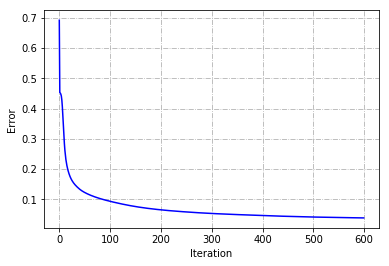

In [9]:
plt.figure()
plt.plot(yy,color = 'b')
plt.grid(b=True,linestyle='-.')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.show()

# Evaluation

In [10]:
accuracy = model.evaluate(x_test,y_test)
print("Accuracy = {0}%".format(accuracy*100))

Accuracy = 83.61111111111111%


# Prediction

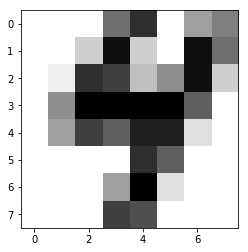

In [16]:
plt.imshow((x_pred[1].reshape(8,8)), cmap=plt.cm.gray_r, interpolation='nearest')

In [17]:
pred = model.predict(np.array(x_pred[1]))
# print(pred)
print(np.argmax(pred))

4
